Note: you may need to restart the kernel to use updated packages.


C:\Users\Yohanan\AppData\Local\Temp\ipykernel_12716\799523353.py:27: DtypeWarning:

Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.



Overall Loss Ratio: 1.05

Loss Ratio by Province:
                LossRatio
Province                
Gauteng         1.222018
KwaZulu-Natal   1.082693
Western,Cape    1.069710
North,West      0.790367
Mpumalanga      0.720897
Free,State      0.680758
Eastern,Cape    0.673492
Limpopo         0.661199
Eastern,"Cape   0.340438
Northern,Cape   0.282699
Western,"Cape   0.055641

Loss Ratio by VehicleType:
                    LossRatio
VehicleType                 
Heavy,Commercial    1.628112
Medium,Commercial   1.050251
Passenger,Vehicle   1.048198
Light,Commercial    0.232066
Bus                 0.137292

Loss Ratio by Gender:
                LossRatio
Gender                  
Not,specified   1.059311
Male            0.883910
Female          0.821879


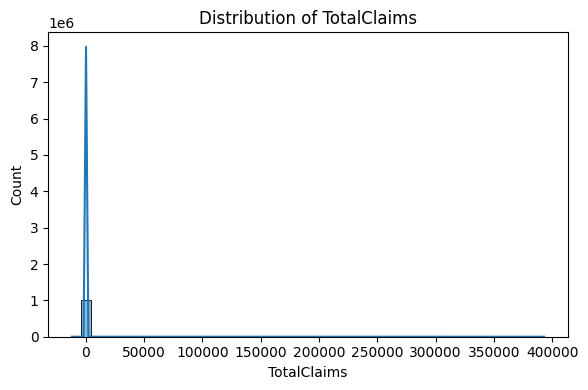

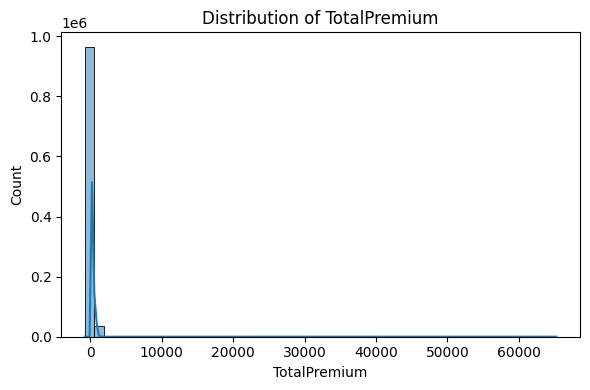

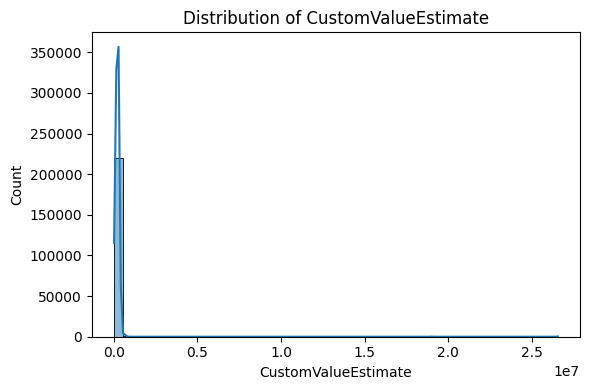

Outliers in TotalClaims: 2793
Outliers in CustomValueEstimate: 1785
Cleaned data saved to MachineLearningRating_v3_cleaned.csv


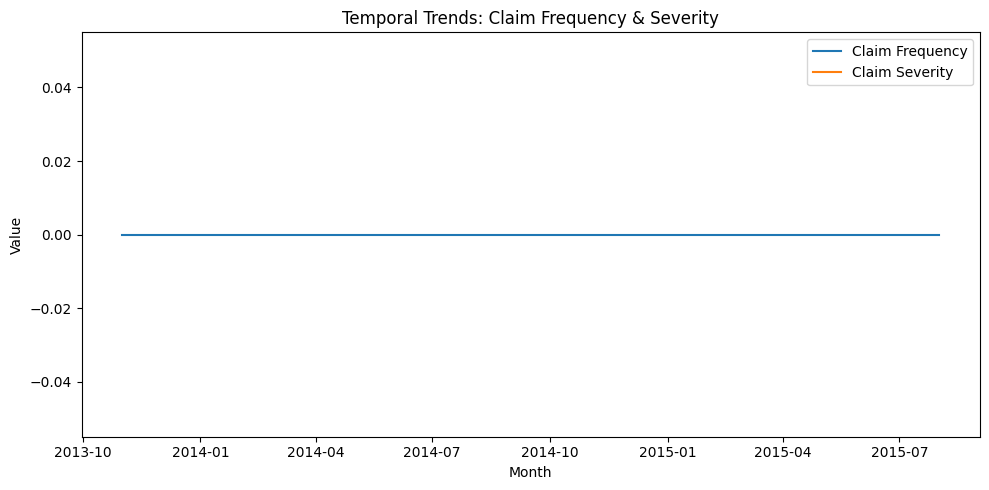

Top 10 Vehicle Makes/Models by Avg. Claim Amount:
    make                        Model  TotalClaims
0   AUDI  A4,1.8T,S,AVANT,MULTITRONIC          0.0
1   AUDI    A4,2.0,TDI,S,,MULTITRONIC          0.0
2   AUDI           A4,2.0,TDI,S,105kW          0.0
3  B.A.W        SASUKA,2.7i,(16,SEAT)          0.0
4    BMW               316i,A/T,(F30)          0.0
5    BMW                   320d,(E90)          0.0
6    BMW               320d,A/T,(E90)          0.0
7    BMW                   320i,(E36)          0.0
8    BMW                   320i,(E90)          0.0
9    BMW                   320i,(F30)          0.0

 Bottom 10 Vehicle Makes/Models by Avg. Claim Amount:
    make                        Model  TotalClaims
0   AUDI  A4,1.8T,S,AVANT,MULTITRONIC          0.0
1   AUDI    A4,2.0,TDI,S,,MULTITRONIC          0.0
2   AUDI           A4,2.0,TDI,S,105kW          0.0
3  B.A.W        SASUKA,2.7i,(16,SEAT)          0.0
4    BMW               316i,A/T,(F30)          0.0
5    BMW                   3

In [31]:
%pip install pandas numpy matplotlib seaborn plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import csv

def txt_to_csv(input_file, output_file, delimiter=' '):
    """Converts a text file to a CSV file.

    Args:
        input_file (str): Path to the input TXT file.
        output_file (str): Path to the output CSV file.
        delimiter (str, optional): Delimiter used in the TXT file. Defaults to ' '.
    """
    with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        reader = csv.reader(infile, delimiter=delimiter)
        writer = csv.writer(outfile)
        for row in reader:
            writer.writerow(row)

# Define the delimiter used in your TXT file
best_delim = '|'  # Set to pipe since your data is pipe-delimited

# Read the TXT file directly into a DataFrame using the specified delimiter
df = pd.read_csv("MachineLearningRating_v3.csv", sep=best_delim)

# Overall Loss Ratio
loss_ratio_overall = df['TotalClaims'].sum() / df['TotalPremium'].sum()
print(f"Overall Loss Ratio: {loss_ratio_overall:.2f}")

# Grouped Loss Ratio by Province, VehicleType, Gender
group_cols = ['Province', 'VehicleType', 'Gender']
for col in group_cols:
    group_loss_ratio = df.groupby(col).agg({'TotalClaims': 'sum', 'TotalPremium': 'sum'})
    group_loss_ratio['LossRatio'] = group_loss_ratio['TotalClaims'] / group_loss_ratio['TotalPremium']
    print(f"\nLoss Ratio by {col}:\n", group_loss_ratio[['LossRatio']].sort_values(by='LossRatio', ascending=False))
# Distributions and Outlier Detection

import seaborn as sns
import matplotlib.pyplot as plt

# Financial variable histograms
fin_vars = ['TotalClaims', 'TotalPremium', 'CustomValueEstimate']
for var in fin_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[var], bins=50, kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Outlier detection using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]
outliers_claims = detect_outliers_iqr(df, 'TotalClaims')
outliers_custom_val = detect_outliers_iqr(df, 'CustomValueEstimate')

print(f"Outliers in TotalClaims: {len(outliers_claims)}")
print(f"Outliers in CustomValueEstimate: {len(outliers_custom_val)}")
df = remove_outliers_iqr(df, 'TotalClaims')
df = remove_outliers_iqr(df, 'CustomValueEstimate')
# Convert TransactionMonth to datetime if needed
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'].str.replace(',', ' ', regex=False))

# Save the cleaned DataFrame to a new CSV file
df.to_csv("MachineLearningRating_v3_cleaned.csv", sep='|', index=False)
print("Cleaned data saved to MachineLearningRating_v3_cleaned.csv")
# Monthly aggregation
df['HasClaim'] = df['TotalClaims'] > 0
monthly_summary = df.groupby(df['TransactionMonth'].dt.to_period('M')).agg(
    ClaimFrequency=('HasClaim', 'mean'),
    ClaimSeverity=('TotalClaims', lambda x: x[x > 0].mean()),
    TotalClaims=('TotalClaims', 'sum'),
    Count=('PolicyID', 'count')
).reset_index()

monthly_summary['TransactionMonth'] = monthly_summary['TransactionMonth'].dt.to_timestamp()

# Plot trends
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_summary, x='TransactionMonth', y='ClaimFrequency', label='Claim Frequency')
sns.lineplot(data=monthly_summary, x='TransactionMonth', y='ClaimSeverity', label='Claim Severity')
plt.title("Temporal Trends: Claim Frequency & Severity")
plt.xlabel("Month")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()
make_model_claims = df.groupby(['make', 'Model'])['TotalClaims'].mean().reset_index()
top_models = make_model_claims.sort_values(by='TotalClaims', ascending=False).head(10)
bottom_models = make_model_claims.sort_values(by='TotalClaims').head(10)

print("Top 10 Vehicle Makes/Models by Avg. Claim Amount:")
print(top_models)

print("\n Bottom 10 Vehicle Makes/Models by Avg. Claim Amount:")
print(bottom_models)



Descriptive Statistics:
        UnderwrittenCoverID       PolicyID               TransactionMonth  \
count        218012.000000  218012.000000                         218012   
mean         145882.876323   10978.806928  2015-04-14 02:56:02.809386752   
min             960.000000     140.000000            2013-11-01 00:00:00   
25%          112711.000000    7071.000000            2015-03-01 00:00:00   
50%          134847.000000   10516.000000            2015-05-01 00:00:00   
75%          184406.000000   13391.000000            2015-07-01 00:00:00   
max          301148.000000   23244.000000            2015-08-01 00:00:00   
std           64879.088581    5475.909135                            NaN   

          PostalCode  RegistrationYear      Cylinders  cubiccapacity  \
count  218012.000000     218012.000000  218012.000000  218012.000000   
mean     2989.065781       2010.508894       4.037860    2502.516889   
min         1.000000       1994.000000       0.000000       0.000000   
2

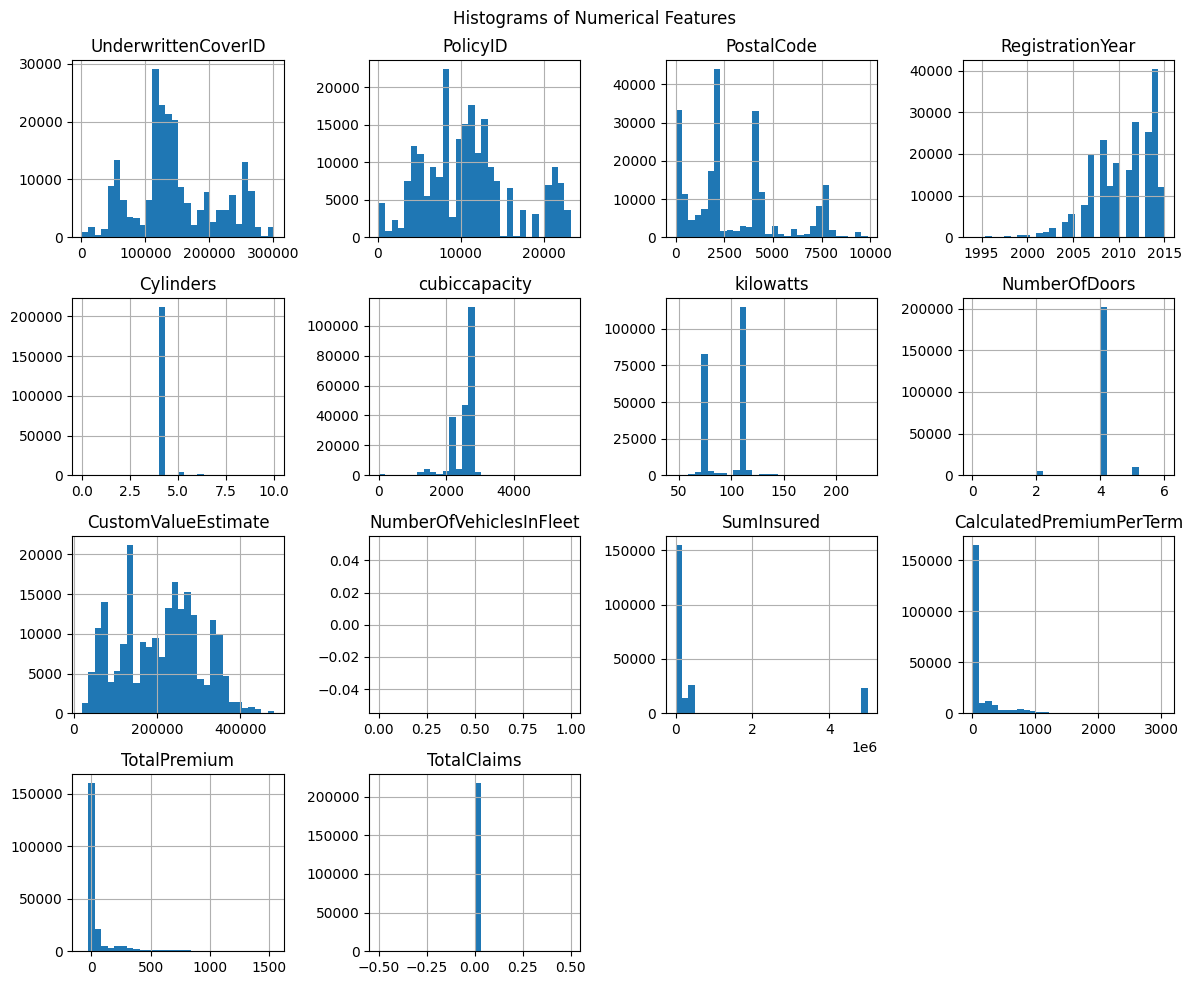

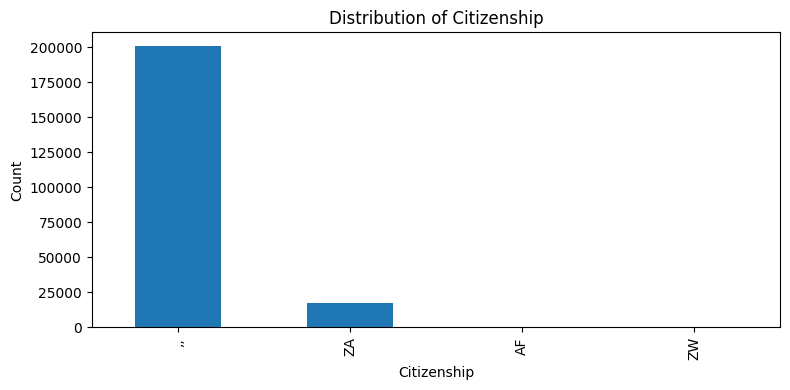

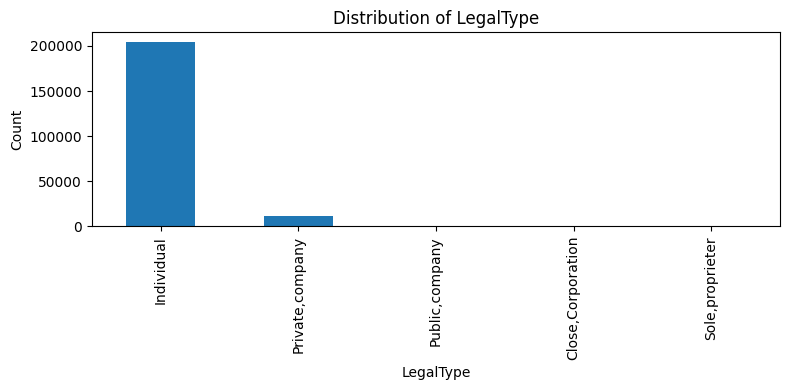

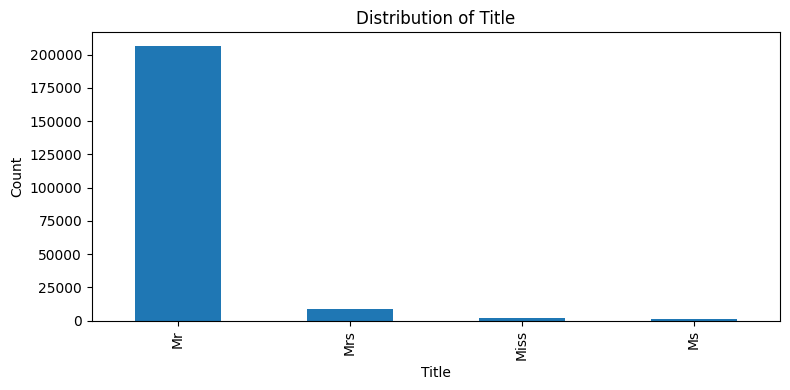

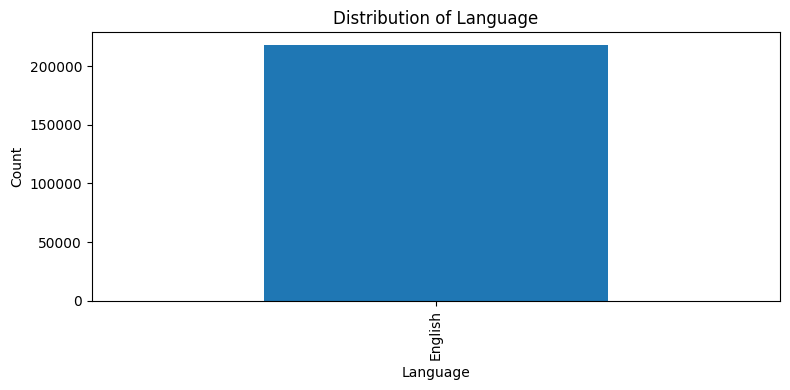

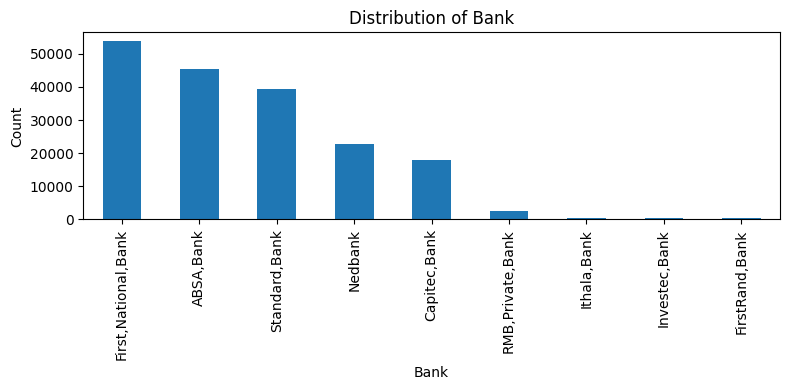

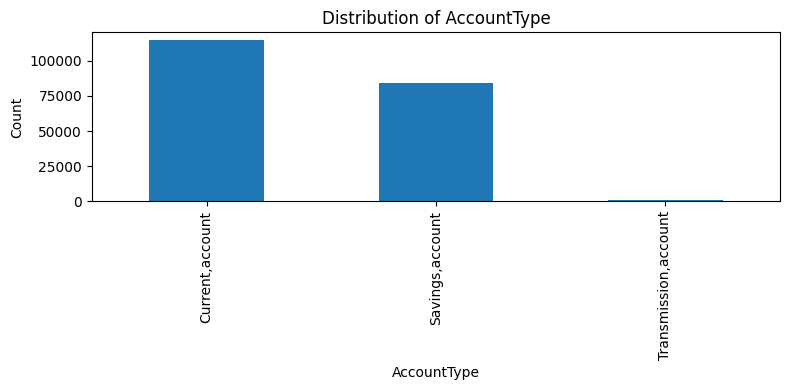

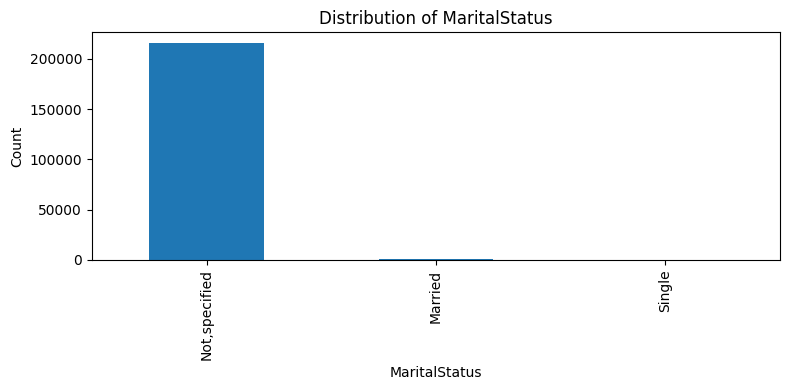

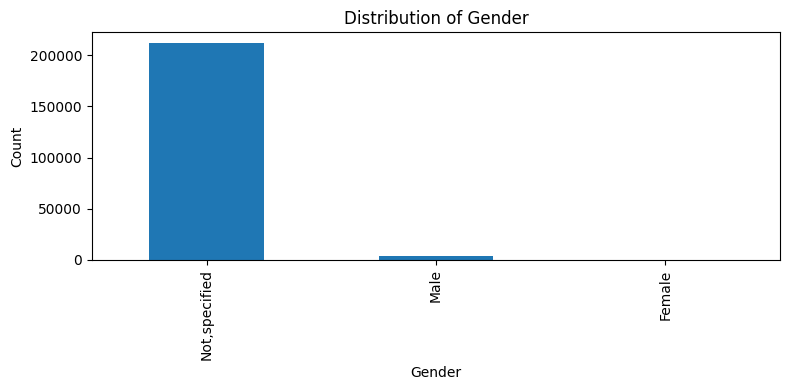

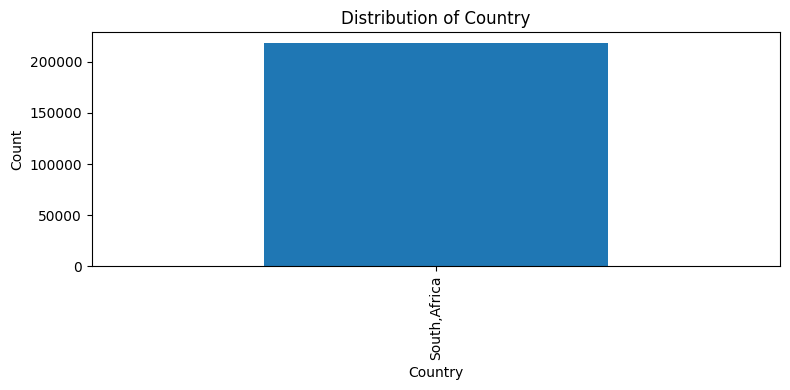

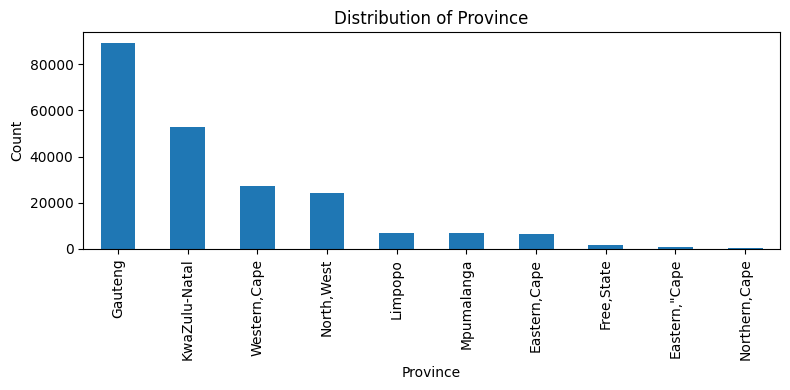

C:\Users\Yohanan\AppData\Local\Temp\ipykernel_12716\3685369736.py:25: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



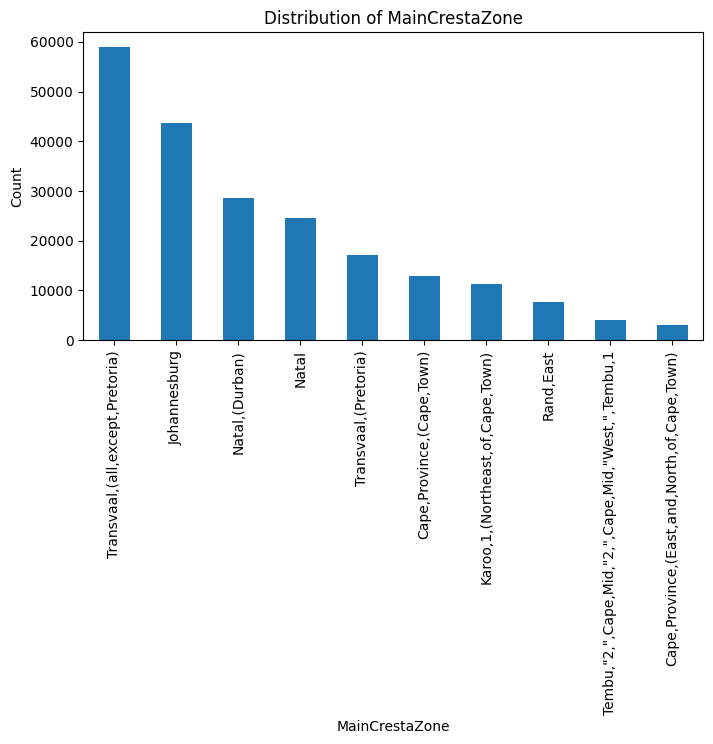

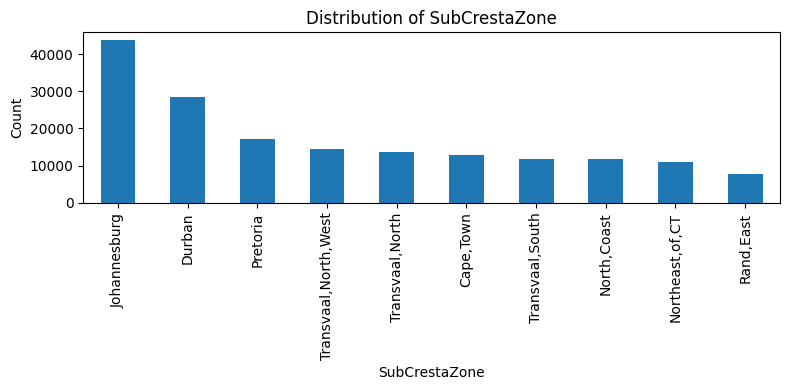

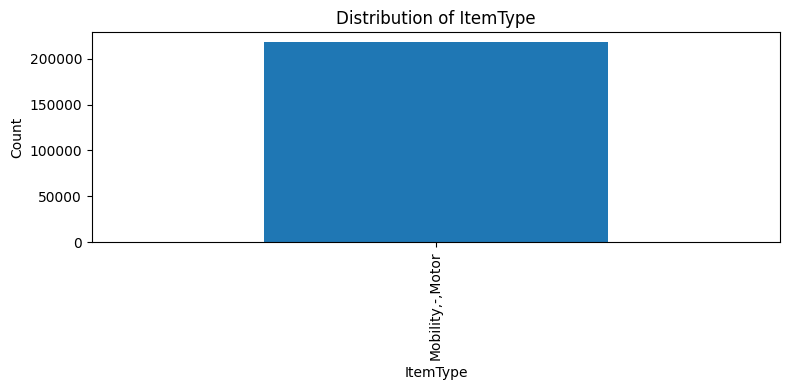

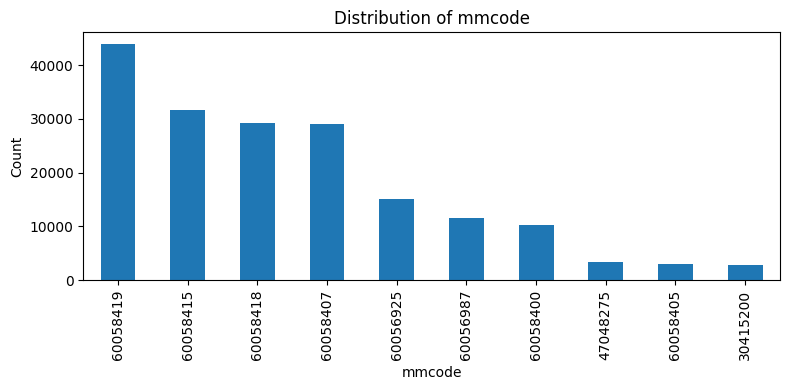

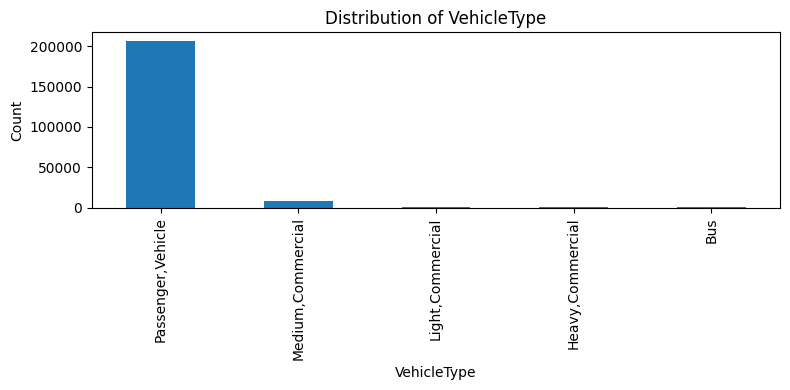

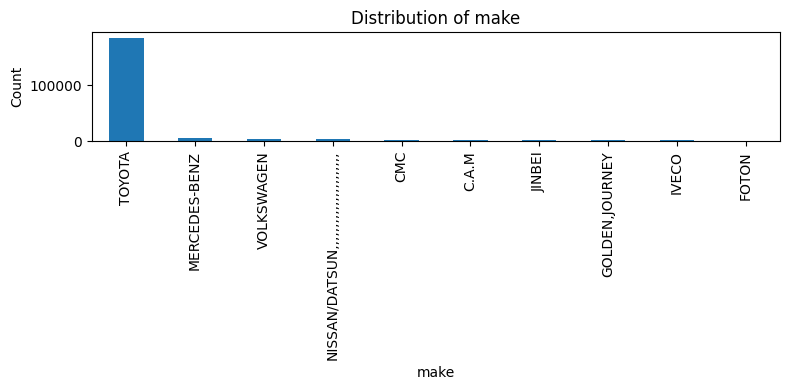

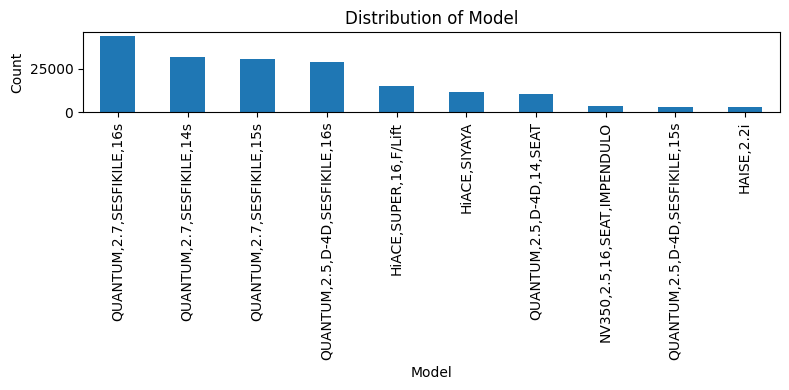

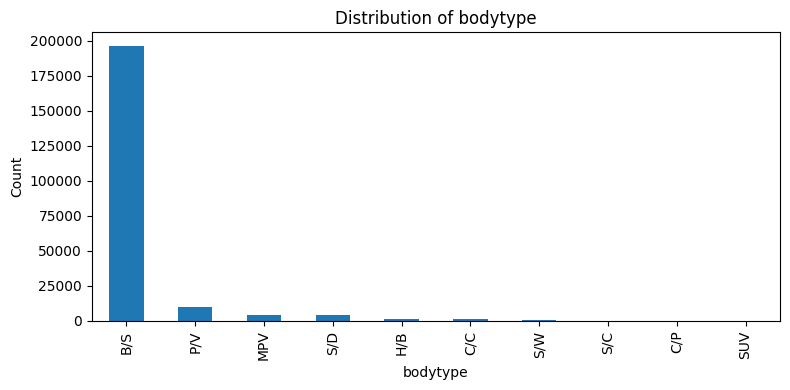

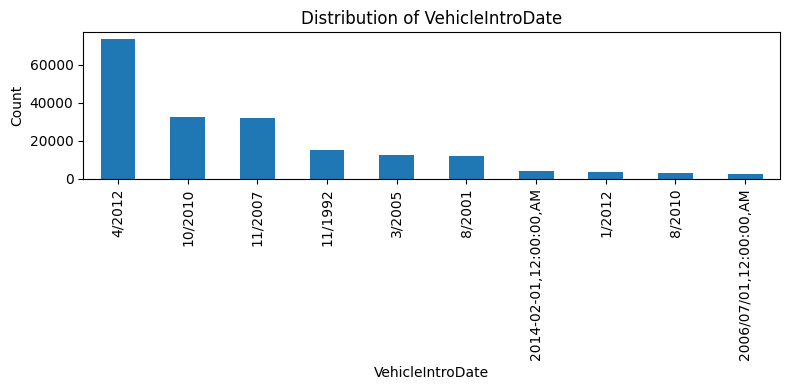

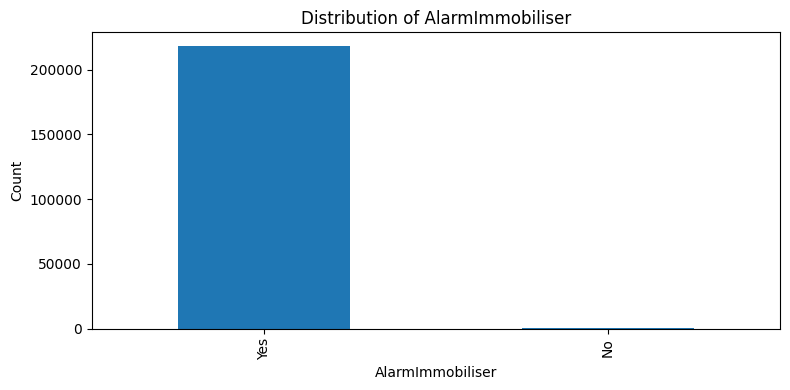

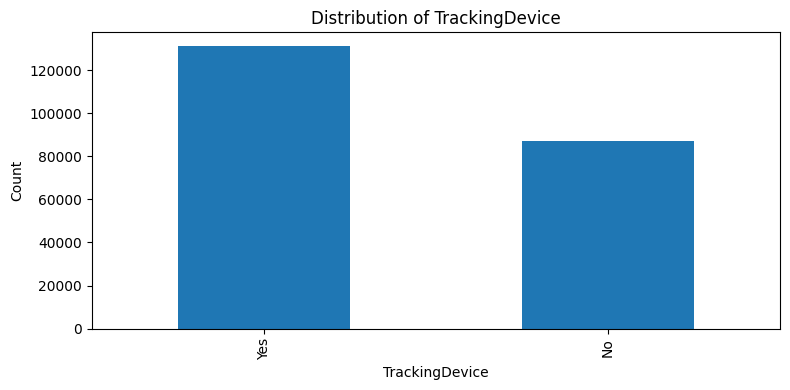

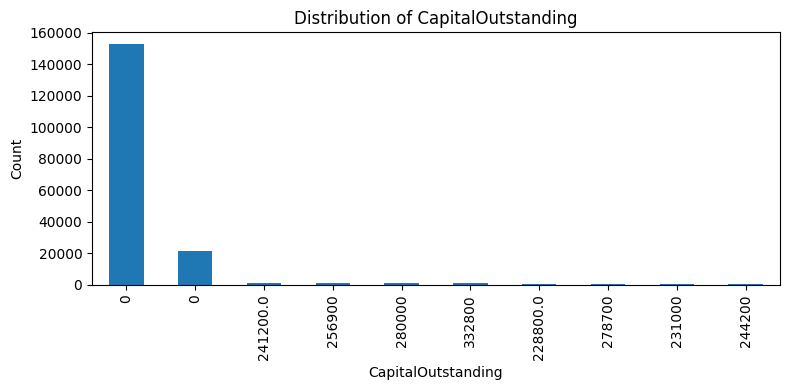

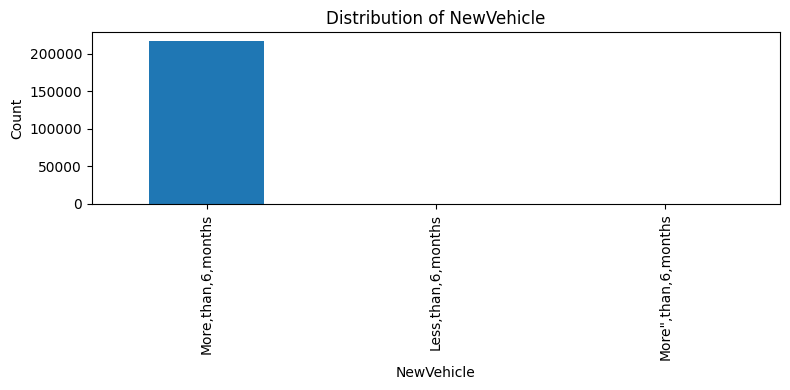

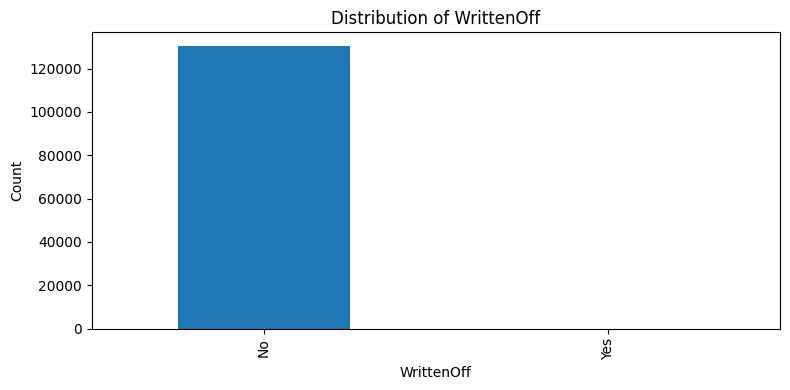

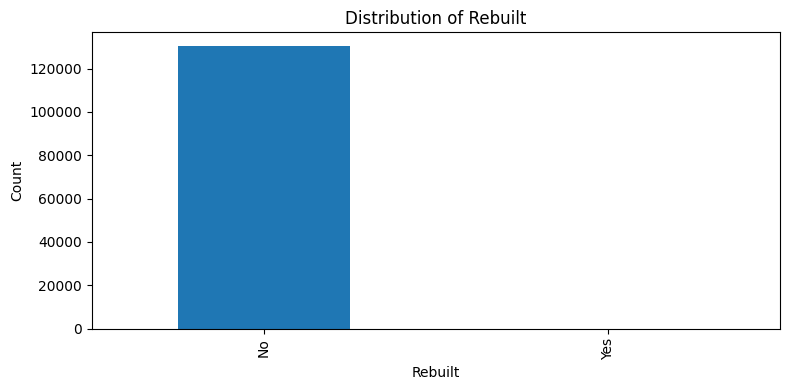

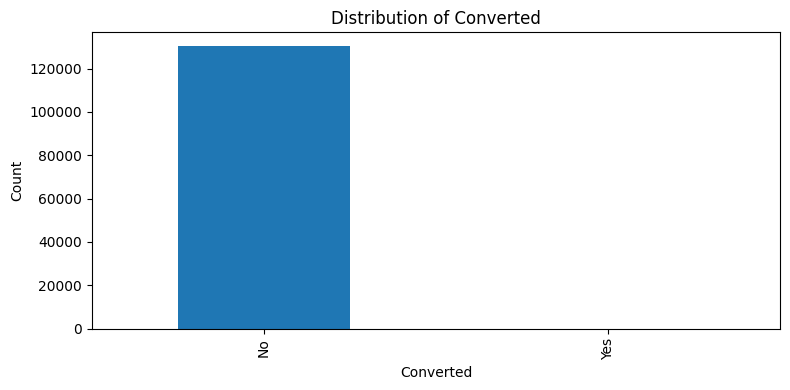

IndexError: index 0 is out of bounds for axis 0 with size 0

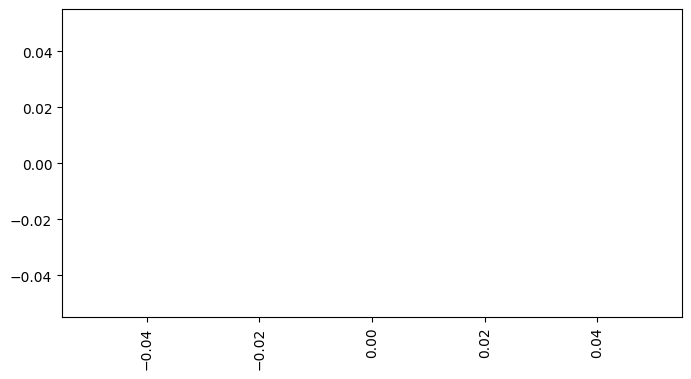

In [32]:
# 1. Data Summarization
## Descriptive statistics
print("\nDescriptive Statistics:\n", df.describe())

## Data types
print("\nData Types:\n", df.dtypes)
# 2. Data Quality Assessment
## Missing values
print("\nMissing Values:\n", df.isnull().sum())  
## Duplicates
print("\nDuplicate Rows:\n", df.duplicated().sum())
# Histograms for numerical columns
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols].hist(figsize=(12, 10), bins=30)
plt.suptitle('Histograms of Numerical Features')
plt.tight_layout()
plt.show()   
# Bar plots for categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    df[col].value_counts().head(10).plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    # 4. Bivariate/Multivariate Analysis
## Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Scatterplot: TotalPremium vs TotalClaim colored by ZipCode
if {'TotalPremium', 'TotalClaim', 'ZipCode'}.issubset(df.columns):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='TotalPremium', y='TotalClaim', hue='ZipCode', palette='tab10')
    plt.title('TotalPremium vs TotalClaim by ZipCode')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    # 5. Data Comparison - Trends over Geography
if 'State' in df.columns:
    geo_df = df.groupby('State').agg({'TotalPremium': 'mean', 'TotalClaim': 'mean'}).reset_index()
    fig = px.choropleth(geo_df, locations='State', locationmode='USA-states',
                        color='TotalPremium', scope='usa',
                        title='Average TotalPremium by State')
    fig.show()
# 6. Outlier Detection
for col in ['TotalPremium', 'TotalClaim']:
    if col in df.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.tight_layout()
        plt.show()
# Plot 1: Interactive scatter
if {'TotalPremium', 'TotalClaim', 'AutoMake'}.issubset(df.columns):
    fig1 = px.scatter(df, x='TotalPremium', y='TotalClaim', color='AutoMake',
                      title='TotalPremium vs TotalClaim by AutoMake')
    fig1.show()

## Plot 2: Time trend (if date and cover type available)
if {'Date', 'CoverType', 'TotalPremium'}.issubset(df.columns):
    trend_df = df.groupby(['Date', 'CoverType'])['TotalPremium'].mean().reset_index()
    fig2 = px.line(trend_df, x='Date', y='TotalPremium', color='CoverType',
                   title='Monthly Premium Trends by Cover Type')
    fig2.show()

## Plot 3: Distribution of Auto Makes
if 'AutoMake' in df.columns:
    auto_counts = df['AutoMake'].value_counts().nlargest(10)
    fig3 = px.bar(auto_counts, x=auto_counts.index, y=auto_counts.values,
                  title='Top 10 Auto Makes in Insurance Data',
                  labels={'x': 'AutoMake', 'y': 'Count'})
    fig3.show()
    

In [33]:
# Plot 1: Interactive scatter
trend_df = df.groupby(['TotalPremium', 'CoverType'])['Country'].mean().reset_index()
fig1 = px.scatter(df, x='TotalPremium', y='country', color='AutoMake',
                      title='TotalPremium vs TotalClaim by AutoMake')
fig1.show()

# Plot 2: Time trend (if date and cover type available)
trend_df = df.groupby(['CalculatedPremiumPerTerm', 'CoverType'])['TotalPremium'].mean().reset_index()
fig2 = px.line(trend_df, x='CalculatedPremiumPerTerm', y='TotalPremium', color='CoverType',
               title='Monthly Premium Trends by Cover Type')
fig2.show()

# Plot 3: Distribution of Auto Makes
if 'AutoMake' in df.columns:
    auto_counts = df['AutoMake'].value_counts().nlargest(10)
    fig3 = px.bar(auto_counts, x=auto_counts.index, y=auto_counts.values,
                  title='Top 10 Auto Makes in Insurance Data',
                  labels={'x': 'AutoMake', 'y': 'Count'})
    fig3.show()

TypeError: agg function failed [how->mean,dtype->object]